# Peak Picking, Integration, and lineshape fitting
## Example Notebook

### Description
This workbook demonstrates how to extract peak heights ('abundance') from a mass spectrrum object, and also how to compute the area (integrated, using a trapezoidal function), and also how to fit the peak lineshape using a defined function (i.e. Gaussian).

#### Author
Will Kew
william.kew@pnnl.gov

#### Version and Release Notes
2021-02-09: Initial version. Demonstrate CoreMS, lmfit, and pso curve fitting. Works with CoreMS - 23.0.1.beta

First, import the key packages for the pipeline

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from corems.transient.input.brukerSolarix import ReadBrukerSolarix
from corems.encapsulation.factory.parameters import MSParameters
%matplotlib inline

Define the data location - here a test dataset included with the repo

Also define the signal processing parameters, including:
1. apodisation ('windowing') function,
2. number of truncations (to the transient),
3. number of zero fills, 
4. and the peak picking method

In [2]:
file_location =  Path("../../tests/tests_data") / "ESI_NEG_SRFA.d"

MSParameters.transient.apodization_method = "Hanning"
MSParameters.transient.number_of_truncations = 0
MSParameters.transient.number_of_zero_fills = 1
MSParameters.mass_spectrum.threshold_method = 'auto'


Read in the bruker file object, read the transient, and then get the mass spectrum object

In [3]:
bruker_reader = ReadBrukerSolarix(file_location)
bruker_transient = bruker_reader.get_transient()
msobj = bruker_transient.get_mass_spectrum(plot_result=False, auto_process=True)


Plot the profile spectrum just to check it loaded OK

<AxesSubplot:xlabel='m/z', ylabel='abundance'>

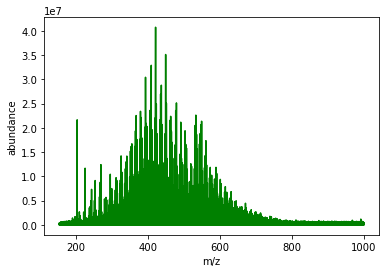

In [4]:
msobj.plot_mz_domain_profile()

Extract a specific peak and plot it to visualise the datapoints 'describing' the peak

(-2946.3695548260994, 9115148.231286455)

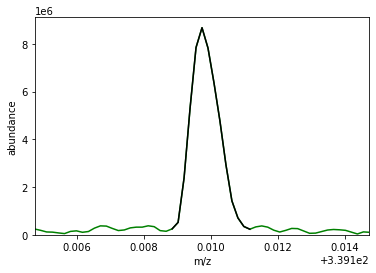

In [5]:
mspeak = msobj.mspeaks[970]   

mzlim = mspeak.mz_exp
ylim = mspeak.abundance
width = 0.005
msobj.plot_mz_domain_profile()
mspeak.plot()

plt.xlim(mzlim-width,mzlim+width)
plt.ylim(0-(np.sqrt(ylim)),ylim*1.05)

Lets report some key properties of the peak:

In [6]:
mspeak.abundance # peak height

8681093.553606147

In [7]:
mspeak.area #integrated area 

8812.292425605207

In [8]:
%%time
mzdom, fit_peak = mspeak.fit_peak()

Wall time: 9 ms


In [9]:
fit_peak.values['amplitude'] #peak area from fit

8888.752916899253

lmfit module produces nice diagnostic plots for curve fitting 

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

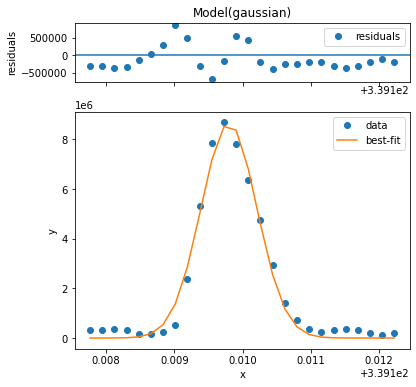

In [10]:
fit_peak.plot()

Figure above shows the fit is reasonably good, however there is a limited digital resolution which makes the overall lineshape appear blocky. Increased zero-filling will better describe the peak shape.

Next, lets plot the profile spectrum with the initial and final fit peakshape superimposed

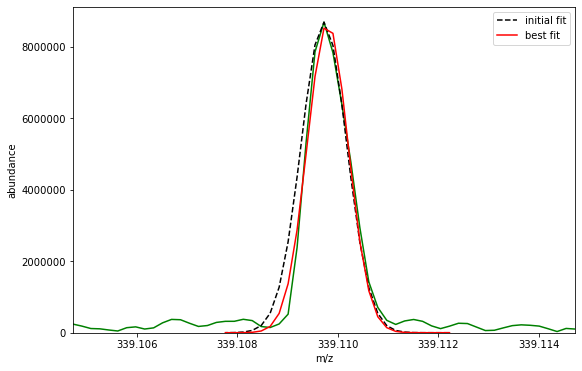

In [11]:
fig,ax=plt.subplots(figsize=(9,6))
msobj.plot_mz_domain_profile()
plt.xlim(mzlim-width,mzlim+width)
plt.ylim(0-(np.sqrt(ylim)),ylim*1.05)
ax.plot(mzdom,fit_peak.init_fit,'k--',label='initial fit')
ax.plot(mzdom,fit_peak.best_fit,'r-',label='best fit')
plt.legend()
ax.ticklabel_format(useOffset=False, style='plain')

##### Redo with improved zero filling
Having seen the fit quality, we can repeat the process with 3x zero filling (not 1) and improve our peakshape

In [12]:
MSParameters.transient.number_of_zero_fills = 3
bruker_reader = ReadBrukerSolarix(file_location)
bruker_transient = bruker_reader.get_transient()
msobj = bruker_transient.get_mass_spectrum(plot_result=False, auto_process=True)


Note the peak index is different - more zero filling has changed the overall number of peaks detected. Generally, more zero-filling is better.

We can also explicitly call a peak function ('gaussian') and a mz_extend value - i.e. how many extra data points in the x-axis to include in the fit. This can help better describe the tails of the broad functions.

8681093.553606147
8754.983301982862
10536.441581626676


339.10967564505614

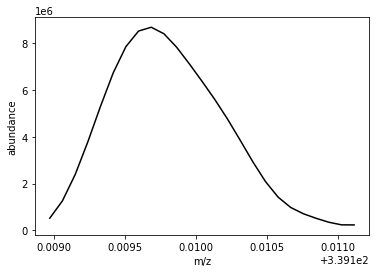

In [13]:
mspeak = msobj.mspeaks[953]  
print(mspeak.abundance) # peak height
print(mspeak.area) #integrated area 
mspeak.plot()
mzdom, fit_peak = mspeak.fit_peak(model='Voigt',mz_extend=20)
print(fit_peak.values['amplitude'])
mspeak.mz_exp

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

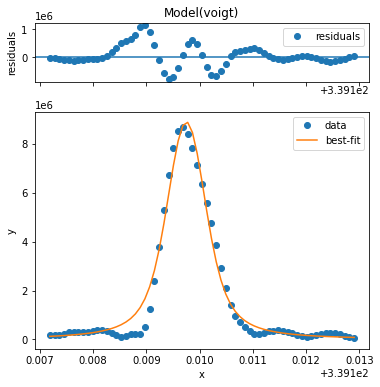

In [14]:
fit_peak.plot()

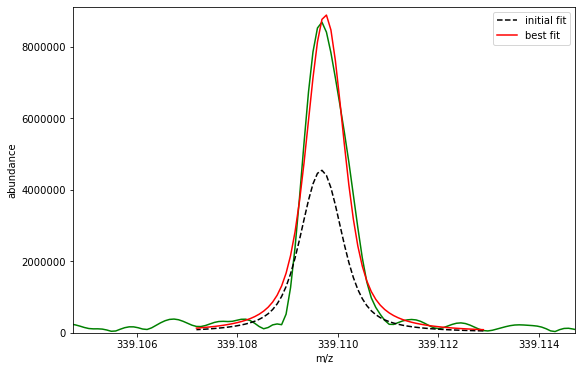

In [15]:
fig,ax=plt.subplots(figsize=(9,6))
msobj.plot_mz_domain_profile()
plt.xlim(mzlim-width,mzlim+width)
plt.ylim(0-(np.sqrt(ylim)),ylim*1.05)
ax.plot(mzdom,fit_peak.init_fit,'k--',label='initial fit')
ax.plot(mzdom,fit_peak.best_fit,'r-',label='best fit')
plt.legend()
ax.ticklabel_format(useOffset=False, style='plain')

## Particle Swarm Optimised Peak Fitting
It is also possible to use pyswarm to fit an optimised peakshape. 
This package is more computationaly expensive than lmfit, but should return more accurate results

In [16]:
%%time
xopt, fopt, psfit, psfit_hdp = mspeak.fit_peak_pso(mz_extend=20)

Stopping search: Swarm best objective change less than 1e-08
Wall time: 2.06 s


Note that the PSO fit took ~2s, whereas the lmfit model took ~10ms. 

Note that the PSO model has currently fixed arguments viz maxiter and swarm size, but these could be optimised or expanded, affecting performance

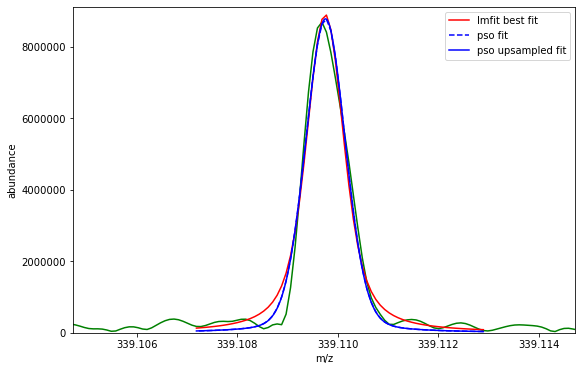

In [17]:
fig,ax=plt.subplots(figsize=(9,6))
msobj.plot_mz_domain_profile()
plt.xlim(mzlim-width,mzlim+width)
plt.ylim(0-(np.sqrt(ylim)),ylim*1.05)
ax.plot(mzdom,fit_peak.best_fit,'r-',label='lmfit best fit')
ax.plot(mzdom,psfit,'b--',label='pso fit')
ax.plot(psfit_hdp[0],psfit_hdp[1],'b-',label='pso upsampled fit')
plt.legend()
ax.ticklabel_format(useOffset=False, style='plain')

For sufficient digital resolution, the PSO fit offers limited advantages over the lmfit model
Interestingly, the precise apex position appears shifted by the voigt fit in either case

## Resolving Power Comparison
CoreMS calculates peak resolving power using the function: 
However, it is possible to compare the calculated resolving power with these fit lineshapes too.

In [18]:
print(mspeak.fwhm) # CoreMS FWHM
print(fit_peak.values['fwhm']) # Lmfit calculated value
print(xopt[1]) # PSO calculated value

0.0009819884043387986
0.000889704854556728
0.0009389898705825434


The peak widths (fwhm) above differ by reasonable amounts. 

Converted to resolving power numbers:

In [19]:
print(mspeak.mz_exp/mspeak.fwhm) # CoreMS FWHM
print(mspeak.mz_exp/fit_peak.values['fwhm']) # Lmfit calculated value
print(mspeak.mz_exp/xopt[1]) # PSO calculated value

345329.61300432927
381148.50549400295
361143.06050466193


We can loop through all the peaks in the msobj and calculate their resolving powers.

Commented out the PSO function as that is much slower

In [20]:
%%time
corems_rp_measure = []
corems_rp_theor = []
lmfit_rp = []
#pso_rp = []
for mspeak in msobj.mspeaks:
    corems_rp_measure.append(mspeak.resolving_power)
    corems_rp_theor.append(mspeak.resolving_power_calc(12,1.1185))
    mzdom, fit_peak = mspeak.fit_peak(model='Voigt',mz_extend=20)
    lmfit_rp.append(mspeak.mz_exp/fit_peak.values['fwhm'])
 #   pso_rp.append(mspeak.resolution)
print(len(msobj.mspeaks))

1093
Wall time: 14.1 s


Note it took ~15s to iterate through 1093 peaks 

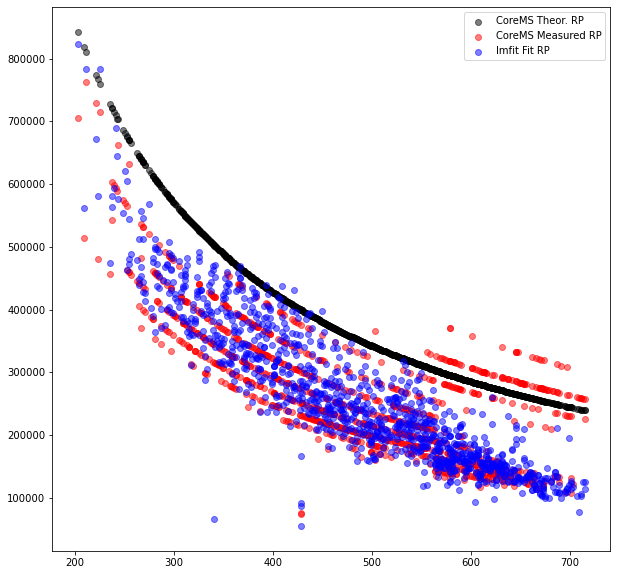

In [21]:
fig,ax = plt.subplots(figsize=(10,10))
xaxis = msobj.mz_exp
ax.scatter(xaxis,corems_rp_theor,c='k',label='CoreMS Theor. RP',alpha=0.5)
ax.scatter(xaxis,corems_rp_measure,c='r',label='CoreMS Measured RP',alpha=0.5)
ax.scatter(xaxis,lmfit_rp,c='b',label='lmfit Fit RP',alpha=0.5)
#ax.plot(pso_rp,'k--',label='PSO Fit RP')
plt.legend()
plt.show()

Note that CoreMS values follow discrete bands, whereas the lmfit values better reflect true resolving powers (which follow continuous distributions)
CoreMS also calculates some values higher-than-possible above m/z 600, whereas lmfit better reflects the true numbers

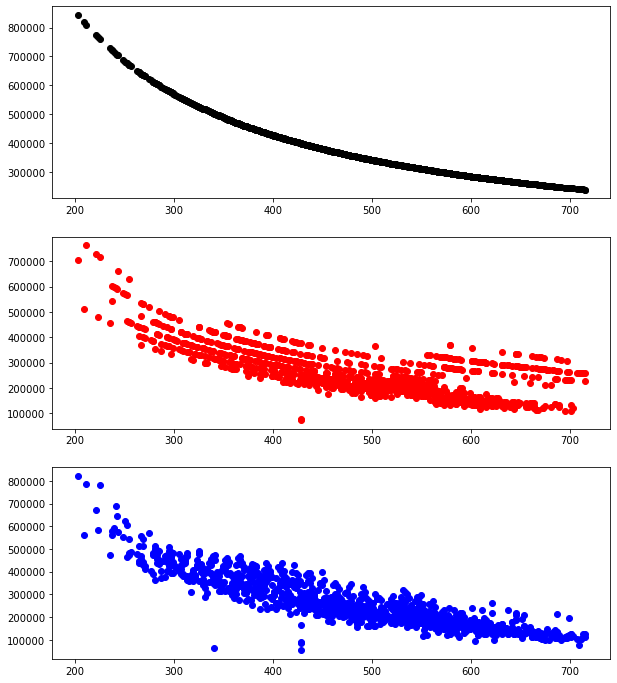

In [22]:
fig,axes = plt.subplots(3,figsize=(10,12))
xaxis = msobj.mz_exp
axes[0].scatter(xaxis,corems_rp_theor,c='k',label='CoreMS Theor. RP')
axes[1].scatter(xaxis,corems_rp_measure,c='r',label='CoreMS Measured RP')
axes[2].scatter(xaxis,lmfit_rp,c='b',label='lmfit Fit RP')
#ax.plot(pso_rp,'k--',label='PSO Fit RP')
plt.show()